<div align="center">

<img src="../docs/assets/app-logo/logo-transparent-bw.png">

## *An AI agent that stands for **S**tructured **M**emory & **A**nalysis with **R**easoning and **T**ools*.

</div>

# **Project Overview**

<p align="justify">

This project focuses on developing an modular **AI Agent for advanced compositional reasoning via semantic memory retrieval and tool integration** that will be benchmarked against the **GAIA-Level-1 dataset**.

</p>

<p align="justify">

To achieve this, we are combining **Retrieval-Augmented Generation** (RAG) and external module-use capabilities with a **Large Language Model** (LLM) as its core guided by a structured **system prompt**.

The main technologies and infrastructure underpinning this system are:

- **LangChain**  
  *Framework for integrating LLMs with external data, tools, APIs, etc.*

- **LangGraph**  
  *Toolkit for building stateful AI workflows with graph-based control.*

- **Supabase**  
  *Vector database for storing and retrieving semantic embeddings.*

- **External APIs**:  
  - **Tavily Search**  
  - **Wikipedia**  
  - **ArXiv**


# **Chapter 1: Analyzing the GAIA Dataset**

## **1.1 Data Description**

<p align="justify">

The **GAIA** (General AI Alignment) dataset is designed as a comprehensive benchmark for evaluating the reasoning skills of artificial intelligence systems, particularly those that interact with real-world environments or perform complex tasks. 

It is structured into three progressive levels, each increasing in complexity: 

<div align="center">

<br>
<table>
  <thead>
    <tr>
      <th style="text-align: center;">Level</th>
      <th style="text-align: center;">Steps</th>
      <th style="text-align: center;">Tool Usage</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align: center;">Level 1</td>
      <td style="text-align: center;">1-5</td>
      <td style="text-align: center;">One</td>
    </tr>
    <tr>
      <td style="text-align: center;">Level 2</td>
      <td style="text-align: center;">5-10</td>
      <td style="text-align: center;">Multiple</td>
    </tr>
    <tr>
      <td style="text-align: center;">Level 3</td>
      <td style="text-align: center;">Unlimited</td>
      <td style="text-align: center;">Advanced</td>
    </tr>
  </tbody>
</table>
<br>

</div>

<p align="justify">

The dataset consists of questions, final answers, and annotated thinking traces. Metadata such as task IDs, tool usage, and temporal constraints enable detailed analysis and agent training.

In this project we use a curated subset of the GAIA-Level-1 collection which offers a balanced set of examples that require multi-hop logic throughout  diverse domains while maintaining computational feasibility.

> <p align="justify">

> ℹ️ <i>Human annotators achieve an average accuracy of 92% on GAIA queries, while current advanced AI systems, such as GPT-4 equipped with plugins, reach only about 15% accuracy</i>.
> </p>


## **1.2 Data Exploration**

<p align="justify">

The initial phase involves loading the *metadata.jsonl* file which contains the challenge data.

In [1]:
# Load the metadata.jsonl file
import json

with open('../src/agent/data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

<p align="justify">

Here it is a random sample to provide an initial view into the format and content.

In [2]:
# Select a random sample
import random

random_samples = random.sample(json_QA, 1)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: 0bdb7c40-671d-4ad1-9ce3-986b159c0ddc
Question: In NASA's Astronomy Picture of the Day on 2006 January 21, two astronauts are visible, with one appearing much smaller than the other. As of August 2023, out of the astronauts in the NASA Astronaut Group that the smaller astronaut was a member of, which one spent the least time in space, and how many minutes did he spend in space, rounded to the nearest minute? Exclude any astronauts who did not spend any time in space. Give the last name of the astronaut, separated from the number of minutes by a semicolon.
Level: 3
Final Answer: White; 5876
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Use search engine to search for "NASA's Astronomy Picture of the Day 2006 January 21".
  │      ├── 2. Open the link to the image.
  │      ├── 3. Read the explanation to find that the image is of astronaut Charles "Pete" Conrad reflected in the helmet of astronaut Alan Bean.
  │      ├── 4. Observe that the smaller astronaut in the image is 

<p align="justify">

Knowing the type of interrogations that are being asked and the responses that are expected to be given, we can begin to build the agent!

# **Chapter 2: Forging the Agent**

## **2.1 Agent's Memory**

<p align="justify">

Its objective is to enhance the agent's ability to recall past knowledge by providing relevant historical information.

This memory system is built using **Supabase** as a vector storage where GAIA records are embedded using **HuggingFace's sentence transformers**.

### **2.1.1 Vector Database Set Up**

<p align="justify">

The process begins with creating and setting up the database.

In [6]:
### Build a vector database: https://python.langchain.com/docs/integrations/vectorstores/supabase/
import os

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import Client, create_client

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")  # dim=768


> <p align="justify">

>  ⬇️ Copy and run this SQL script in your <b>Supabase SQL Editor</b> proyect ⬇️

```sql
-- 1️⃣ Clean up existing objects

DROP FUNCTION IF EXISTS public.match_documents_langchain(vector, integer);
DROP TABLE IF EXISTS public.documents;

-- 2️⃣ Install vector extension

DROP EXTENSION IF EXISTS vector;
CREATE SCHEMA IF NOT EXISTS extensions;
CREATE EXTENSION IF NOT EXISTS vector WITH SCHEMA extensions;

-- 3️⃣ Create documents table

CREATE TABLE public.documents (
  id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
  content TEXT,
  metadata JSONB,
  embedding extensions.vector(768)
);

-- 4️⃣ Enable Row Level Security (RLS)

ALTER TABLE public.documents ENABLE ROW LEVEL SECURITY;

-- 5️⃣ Add open access policy

CREATE POLICY "Allow all access"
ON public.documents
FOR ALL
USING (true)
WITH CHECK (true);

-- 6️⃣ Create vector search function

CREATE OR REPLACE FUNCTION public.match_documents_langchain(
  query_embedding extensions.vector(768),
  match_count INT DEFAULT 5
)
RETURNS TABLE (
  id UUID,
  content TEXT,
  metadata JSONB,
  similarity FLOAT
)
LANGUAGE sql
STABLE
SET search_path = public, extensions
AS $$
  SELECT
    id,
    content,
    metadata,
    1 - (embedding <#> query_embedding) AS similarity
  FROM
    public.documents
  ORDER BY
    embedding <#> query_embedding
  LIMIT match_count;
$$;


### **2.1.1 Data Ingestion**

<p align="justify">

The next step involves transforming our set of Q&A into document embeddings to store them.

In [ ]:
# Wrap the metadata.jsonl's questions and answers into a list of document
docs = []
for sample in json_QA:
    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {
        "content" : content,
        "metadata" : {
            "source" : sample['task_id']
        },
        "embedding" : embeddings.embed_query(content),
    }
    docs.append(doc)

# Upload the documents to the vector database
try:
    response = (
        supabase.table("documents")
        .insert(docs)
        .execute()
    )
except Exception as exception:
    print("Error inserting data into database:", exception)

### **2.1.2 Retriever Builder**

<p align="justify">

Finally, a retriever is created to enable semantic search across the knowledge base.

In [7]:
# Add items to vector database
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents_langchain",
)
retriever = vector_store.as_retriever()

## **2.2 Tool Arsenal**

<p align="justify">

Its objective is to extend the agent's capabilities beyond its internal knowledge by providing external resources that allow it to tackle complex challenges and diverse reasoning challenges.

These tools are built using **LangChain** to integrate the LLM with external modules and APIs, including mathematical operations and query processing utilities like **Tavily Search**, **Wikipedia**, and **ArXiv**.

### **2.2.1 Mathematical Tools**

<p align="justify">

Basic arithmetic operations form the foundation of quantitative analysis.

In [8]:
from langchain_community.document_loaders import ArxivLoader, WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import StructuredTool, Tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field

# ---------- Pydantic schemas for math tools ----------
class MathInput(BaseModel):
    a: int = Field(description="First number")
    b: int = Field(description="Second number")

# ---------- Math tools ----------
def multiply_fn(a: int, b: int) -> int:
    return a * b

multiply = StructuredTool.from_function(
    func=multiply_fn,
    name="multiply",
    description="Multiply two numbers",
    args_schema=MathInput
)

def add_fn(a: int, b: int) -> int:
    return a + b

add = StructuredTool.from_function(
    func=add_fn,
    name="add",
    description="Add two numbers",
    args_schema=MathInput
)

def subtract_fn(a: int, b: int) -> int:
    return a - b

subtract = StructuredTool.from_function(
    func=subtract_fn,
    name="subtract",
    description="Subtract two numbers",
    args_schema=MathInput
)

def divide_fn(a: int, b: int) -> float:
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

divide = StructuredTool.from_function(
    func=divide_fn,
    name="divide",
    description="Divide two numbers",
    args_schema=MathInput
)

def modulus_fn(a: int, b: int) -> int:
    return a % b

modulus = StructuredTool.from_function(
    func=modulus_fn,
    name="modulus",
    description="Modulus of two numbers",
    args_schema=MathInput
)

### **2.2.2 Knowledge Retrieval Tools**

<p align="justify">

Information retrieval capabilities are essential for accessing both structured and unstructured data sources.

In [9]:
# ---------- Wikipedia search ----------
def wiki_search_fn(input: str) -> str:
    search_docs = WikipediaLoader(query=input, load_max_docs=2).load()
    formatted = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return formatted

wiki_search = Tool.from_function(
    func=wiki_search_fn,
    name="wiki_search",
    description="Search Wikipedia for a query and return up to 2 results."
)

# ---------- Web search ----------
def web_search_fn(input: str) -> str:
    search_results = TavilySearchResults(max_results=3).invoke(input)
    
    formatted_results = []
    for i, result in enumerate(search_results):
        url = result.get('url', 'No URL')
        title = result.get('title', 'No Title')
        content = result.get('content', 'No Content')
        
        formatted_doc = f'<Document source="{url}" title="{title}"/>\n{content}\n</Document>'
        formatted_results.append(formatted_doc)
    
    return "\n\n---\n\n".join(formatted_results)

web_search = Tool.from_function(
    func=web_search_fn,
    name="web_search",
    description="Search Tavily for a query and return up to 3 results."
)

# ---------- ArXiv search ----------
def arxiv_search_fn(input: str) -> str:
    try:
        search_docs = ArxivLoader(query=input, load_max_docs=3).load()
        formatted = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata.get("source", "arXiv")}" title="{doc.metadata.get("title", "")}" entry_id="{doc.metadata.get("entry_id", "")}"/>\n{doc.page_content[:1000]}...\n</Document>'
                for doc in search_docs
            ]
        )
        return formatted
    except Exception as e:
        return f"Error searching arXiv: {str(e)}"

arxiv_search = Tool.from_function(
    func=arxiv_search_fn,
    name="arxiv_search",
    description="Search Arxiv for a query and return up to 3 results."
)

## **2.3 System Prompt**

<p align="justify"> 

Its objective is to establish clear thought process patterns for consistent and methodical problem-solving.

In [ ]:
system_prompt = """
You are a reasoning assistant that answers questions step by step using tools when needed.

CRITICAL: You MUST follow the exact format specified below. Do not deviate from this structure.

Your tasks:
- Break down your thinking into clear numbered steps that explain your thinking
- Use internal knowledge and the available tools to solve the queries
- Specify each tool used and why you chose it
- End with a direct final reply

AVAILABLE TOOLS: You have access to multiply, add, subtract, divide, modulus, wiki_search, web_search, and arxiv_search. Choose the most appropriate tool for each job.

==========================
MANDATORY FORMAT - Follow this EXACTLY:

Steps:
1. [IDENTIFY] :             State what you need to find or decide
2. [USE] :                  Specify the tool you will use and justify why
3. [<ANY ACCURATE VERB>] :  Perform your actions step-by-step
4. [RESULT] :               Present the final outcome from your deduction


Final Answer:
Your direct, concise response

==========================

EXAMPLES OF PROPER FORMAT:

Example 1:
Steps:
1. [IDENTIFY] : Find the Fahrenheit equivalent of 25°C
2. [USE] : Use the formula F = (C × 9/5) + 32 for conversion
3. [MULTIPLY] : Calculate 25 × 9 = 225
4. [DIVIDE] : Calculate 225 ÷ 5 = 45
5. [ADD] : Add 45 + 32 = 77
6. [RESULT] : The temperature is 77°F

Final Answer:
77°F

Example 2:
Steps:
1. [IDENTIFY] : Determine the capital city of Australia
2. [USE] : Use web search to get knowledge about Australian geography
3. [RECALL] : The capital is Canberra, chosen as a compromise between Sydney and Melbourne
4. [RESULT] : Canberra is the official capital city

Final Answer:
Canberra

==========================

REQUIREMENTS:

> FORMAT RULES:
    - Use the exact headers "Steps:" and "Final Answer:" without any markdown formatting.
    - Number each step sequentially: 1, 2, 3, etc.
    - Format each step as: [ACTION VERB] : [explanation]
    - No markdown symbols anywhere

> TOOL INTEGRATION:
    - Mathematical tools: multiply, add, subtract, divide, modulus (arithmethic)
    - Knowledge tools: web_search (current info), wiki_search (facts), arxiv_search (academic)

==========================

FINAL REMINDER:
Explain WHY you make each decision and HOW you solve the problem step by step.
"""

# ---------- System Message ----------
sys_msg = SystemMessage(content=system_prompt)

## **2.4 Large Language Model (LLM)**

<p align="justify">

Its objective is to act as the agent's central reasoning engine. It is in charge of processing inputs, dynamically selecting appropriate resources during decision-making and generating replies.

The selected LLM on this ocassion is **ChatGroq** (*qwen/qwen3-32b*). All tools programmatically bound to it for dynamic functionality leverage.

In [11]:
import dotenv

dotenv.load_dotenv()

# ---------- LLM ----------
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)

# ---------- Tools list ----------
tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arxiv_search
]

llm_with_tools = llm.bind_tools(tools)

# **Chapter 3: Agent Workflow Architecture**

<p align="justify">

The agent's operational flow is guided by a framework called **LangGraph** that enables sophisticated state management and conditional routing.

The pipeline consists of three primary nodes, each one serving a distinct role in the solution generation process:

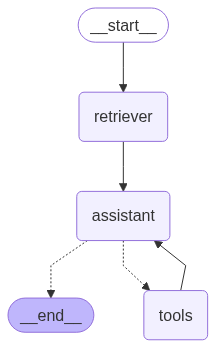

In [12]:
#Nodes
from IPython.display import Image, display

def assistant(state: MessagesState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
def retriever(state: MessagesState):
    similar_question = vector_store.similarity_search(state["messages"][0].content)
    example_msg = HumanMessage(
        content=f"Here I provide a similar question and answer for reference: \n\n{similar_question[0].page_content}",
    )
    return {"messages": [sys_msg] + state["messages"] + [example_msg]}

builder = StateGraph(MessagesState)
builder.add_node("retriever", retriever)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "retriever")
builder.add_edge("retriever", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

<p align="justify">

In summary, the process kicks off with the retriever pulling in relevant contextual examples to enrich the input. This enriched context is then passed to the assistant, which begins reasoning over it. As the rationalization unfolds, the assistant can call on external tools when needed, seamlessly merging their outputs to refine and complete its response.

The workflow unfolds as follows:

- **Retriever Node:**  
  *The retriever locates semantically related questions from the memory database upon receiving a request to get contextual examples to enhance the setting.*

- **Assistant Node:**  
  *The assistant integrates the enriched context — combining the system prompt, the original query and fetched examples. It decides whether to respond directly or trigger a callable operation.*

- **Tools Node:**  
  *The tools execute specific tasks as needed with their outputs seamlessly fed back to the assistant to support following further considerations.*


This iterative approach enables the agent to engage in multi-step deliberation by gradually building toward a comprehensive solution while maintaining transparency throughout its decision-making process.


# **Chapter 4: Validation and Performance**

<p align="justify">

We've successfully assembled all our vital components!

To ensure everything functions as intended before deploying it on complex challenges, it is essential to conduct a systematic validation of each module.

## **4.1 Comprehensive Tool Testing**

<p align="justify">

The following test cases demonstrate the agent’s capabilities across different cognitive domains.

### **4.1.1 Mathematical Analysis Validation**

In [13]:
question = "What is 25 + 17?"  # Math tool
messages = [HumanMessage(content=question)]
result = graph.invoke({"messages": messages})

print(result['messages'][-1].content)

Steps:
1. [IDENTIFY] : Calculate the sum of 25 and 17
2. [USE] : Use the add function for basic arithmetic
3. [ADD] : Perform 25 + 17 = 42
4. [RESULT] : The sum is 42

Final Answer:
42


### **4.1.2 Knowledge Base Retrieval Validation**

In [14]:
question = "According to Wikipedia, what was the name of the machine Alan Turing proposed to break the Enigma code?"  # Wikipedia
messages = [HumanMessage(content=question)]
result = graph.invoke({"messages": messages})

print(result['messages'][-1].content)

Steps:
1. [IDENTIFY] : Find the name of the machine Alan Turing proposed to break the Enigma code as documented on Wikipedia.
2. [USE] : Use wiki_search to query Wikipedia for precise historical records on Turing's contributions to breaking the Enigma code.
3. [CALL] : Execute the search with the query "Alan Turing Enigma code machine".
4. [RESULT] : Wikipedia states that Turing designed the "Bombe," an electromechanical device used to decipher Enigma-encrypted messages during World War II.

Final Answer:
The Bombe


### **4.1.3 Real-Time Information Access Validation**

In [15]:
question = "Summarize the latest AI technologies or innovations" # Web search
messages = [HumanMessage(content=question)]
result = graph.invoke({"messages": messages})

print(result['messages'][-1].content)

Steps:
1. [IDENTIFY] : Gather recent advancements in AI technologies or innovations from credible sources.
2. [USE] : Use web_search to find up-to-date information on recent AI developments.
3. [SEARCH] : Execute query "latest AI technologies 2024 innovations" to retrieve current trends.
4. [ANALYZE] : Review search results for key themes like generative AI, multimodal models, efficiency breakthroughs, and industry applications.
5. [RESULT] : Synthesize findings into a concise summary of major innovations.

Final Answer:
Recent AI advancements include multimodal models (e.g., Google's Gemini), efficient inference techniques (e.g., quantization), AI-driven drug discovery, and ethical frameworks for responsible AI. Notable innovations also involve reinforcement learning in robotics and open-source large language models like Meta's Llama 3.


### **4.1.4 Academic Literature Search Validation**

In [16]:
question = "Find arXiv papers on quantum computing"  # ArXiv
messages = [HumanMessage(content=question)]
result = graph.invoke({"messages": messages})

print(result['messages'][-1].content)

Steps:
1. [IDENTIFY] : Retrieve arXiv papers related to quantum computing
2. [USE] : Use arxiv_search to find relevant academic papers on quantum computing
3. [SEARCH] : Execute arxiv_search with query "quantum computing"
4. [RESULT] : Found 3 relevant papers including "The Rise of Quantum Internet Computing" (arXiv:2208.00733v1), "Unconventional Quantum Computing Devices" (arXiv:quant-ph/0003151v1), and "Geometrical perspective on quantum states" (arXiv:1311.4939v1)

Final Answer:
Three arXiv papers on quantum computing were found:
1. arXiv:2208.00733v1 - "The Rise of Quantum Internet Computing" (August 2022)
2. arXiv:quant-ph/0003151v1 - "Unconventional Quantum Computing Devices" (March 2000)
3. arXiv:1311.4939v1 - "Geometrical perspective on quantum states" (November 2013)


# **Chapter 5:  Conclusion and Future Perspectives**

## **5.1 Project Summary**

<p align="justify">

The agent demonstrates significant improvements over baseline LLMs by incorporating methodical task resolution approaches with expanded information retrieval and specialized operational modules.

## **5.2 Future Directions and AI Agent Trends**

<p align="justify">

The AI landscape is rapidly evolving toward more sophisticated systems with emphasis on **Explainable AI** (XAI) integration. Modern systems must provide transparent decision pathways and interpretable reasoning processes—our structured methodology supports this essential requirement as understandability becomes crucial for trust, regulatory compliance and responsible deployment.

Furthermore, emerging trends include **multi-agent collaborative systems** where specialized entities contribute unique expertise to collective troubleshooting through domain-specific capabilities and continuously adapt and optimize their own performance.

The future lies in systems that explain their thinking and enhance human intelligence rather than replace it.

> <br>
> <p style="text-align: center;"><b><i>The future belongs to systems that think alongside us, not for us.</i></b></p>
> <br>
> <br>
> <p style="text-align: center;"> <i>The global AI agents market size was valued at USD 5.43 billion in 2024 and is expected to hit around USD 236.03 billion by 2034, growing at a CAGR of 45.82% AI Market Size to Hit USD 236.03 Billion by 2034 — a 43x growth that signals we're not just building better tools, but architecting the next evolution of human-machine collaboration</i></p>
> <br>
> <br>
> <br>